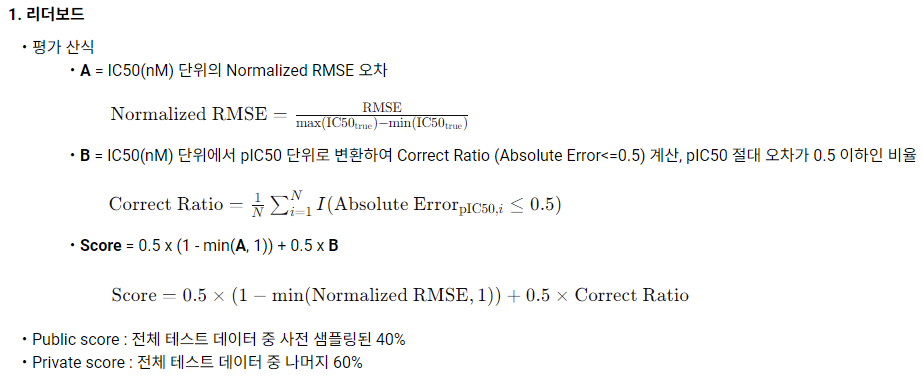

# Import

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import os
import random

In [4]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.metrics import mean_squared_error
from math import log10, sqrt

In [5]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [6]:
!pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.1/33.1 MB 50.0 MB/s eta 0:00:00


In [7]:
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.model_selection import train_test_split

# Data

## Data Load

In [8]:
chembl_data = pd.read_csv('/content/drive/MyDrive/DACON/제2회 신약개발 AI 경진대회/open/train.csv')
test_data = pd.read_csv('/content/drive/MyDrive/DACON/제2회 신약개발 AI 경진대회/open/test.csv')

In [9]:
num_chembl = len(chembl_data['Assay ChEMBL ID'].unique())
num_smiles = len(chembl_data['Smiles'].unique())

print('Number of Assay ChEMBL IDs', num_chembl)
print('Number of Smiles', num_smiles)

Number of Assay ChEMBL IDs 72
Number of Smiles 1952


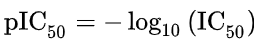

In [9]:
chembl_data.head()

,Molecule ChEMBL ID,Standard Type,Standard Relation,Standard Value,Standard Units,pChEMBL Value,Assay ChEMBL ID,Target ChEMBL ID,Target Name,Target Organism,Target Type,Document ChEMBL ID,IC50_nM,pIC50,Smiles
0,CHEMBL4443947,IC50,'=',0.022,nM,10.66,CHEMBL4361896,CHEMBL3778,Interleukin-1 receptor-associated kinase 4,Homo sapiens,SINGLE PROTEIN,CHEMBL4359855,0.022,10.66,CN[C@@H](C)C(=O)N[C@H](C(=O)N1C[C@@H](NC(=O)CC...
1,CHEMBL4556091,IC50,'=',0.026,nM,10.59,CHEMBL4345131,CHEMBL3778,Interleukin-1 receptor-associated kinase 4,Homo sapiens,SINGLE PROTEIN,CHEMBL4342485,0.026,10.59,CC(C)(O)[C@H](F)CN1Cc2cc(NC(=O)c3cnn4cccnc34)c...
2,CHEMBL4566431,IC50,'=',0.078,nM,10.11,CHEMBL4345131,CHEMBL3778,Interleukin-1 receptor-associated kinase 4,Homo sapiens,SINGLE PROTEIN,CHEMBL4342485,0.078,10.11,CC(C)(O)[C@H](F)CN1Cc2cc(NC(=O)c3cnn4cccnc34)c...
3,CHEMBL4545898,IC50,'=',0.081,nM,10.09,CHEMBL4345131,CHEMBL3778,Interleukin-1 receptor-associated kinase 4,Homo sapiens,SINGLE PROTEIN,CHEMBL4342485,0.081,10.09,CC(C)(O)[C@H](F)CN1Cc2cc(NC(=O)c3cnn4cccnc34)c...
4,CHEMBL4448950,IC50,'=',0.099,nM,10.00,CHEMBL4361896,CHEMBL3778,Interleukin-1 receptor-associated kinase 4,Homo sapiens,SINGLE PROTEIN,CHEMBL4359855,0.099,10.00,COc1cc2c(OC[C@@H]3CCC(=O)N3)ncc(C#CCCCCCCCCCCC...


## Data Pre-processing

In [10]:
# Function to generate ECFP fingerprint from SMILES
def generate_ecfp(smiles, radius=2, nBits=2048):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        raise ValueError("Invalid SMILES string")
    ecfp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=nBits)
    return ecfp

In [ ]:
# smiles to ECFP fingerprint
dataset = chembl_data[['Assay ChEMBL ID', 'IC50_nM', 'pIC50', 'Smiles']].copy()
dataset.loc[:, 'ECFP'] = dataset['Smiles'].apply(generate_ecfp)
ecfp_array = np.array(dataset['ECFP'].tolist())

# assay chembl id 정수 변환
dataset['Assay ChEMBL ID'] = dataset['Assay ChEMBL ID'].str.extract('(\d+)', expand=False).astype(int)

In [12]:
dataset

,Assay ChEMBL ID,IC50_nM,pIC50,Smiles,ECFP
0,4361896,0.022,10.66,CN[C@@H](C)C(=O)N[C@H](C(=O)N1C[C@@H](NC(=O)CC...,"[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
1,4345131,0.026,10.59,CC(C)(O)[C@H](F)CN1Cc2cc(NC(=O)c3cnn4cccnc34)c...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
2,4345131,0.078,10.11,CC(C)(O)[C@H](F)CN1Cc2cc(NC(=O)c3cnn4cccnc34)c...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
3,4345131,0.081,10.09,CC(C)(O)[C@H](F)CN1Cc2cc(NC(=O)c3cnn4cccnc34)c...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
4,4361896,0.099,10.00,COc1cc2c(OC[C@@H]3CCC(=O)N3)ncc(C#CCCCCCCCCCCC...,"[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...
1947,870864,30000.000,4.52,O=C(Nc1nc2cc[nH]cc-2n1)c1cccc([N+](=O)[O-])c1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1948,870864,30000.000,4.52,CCCCn1c(NC(=O)c2cccc(Cl)c2)nc2ccccc21,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1949,870864,30000.000,4.52,O=C(Nc1nc2cc(F)c(F)cc2[nH]1)c1cccc([N+](=O)[O-...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1950,3407004,42000.000,4.38,OC[C@H]1C[C@@H](Nc2nc(Nc3ccccc3)ncc2-c2nc3cccc...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


## 시각화

<ipython-input-13-6079ab7d1e5b>:29: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(dataset['pIC50'], shade=True)


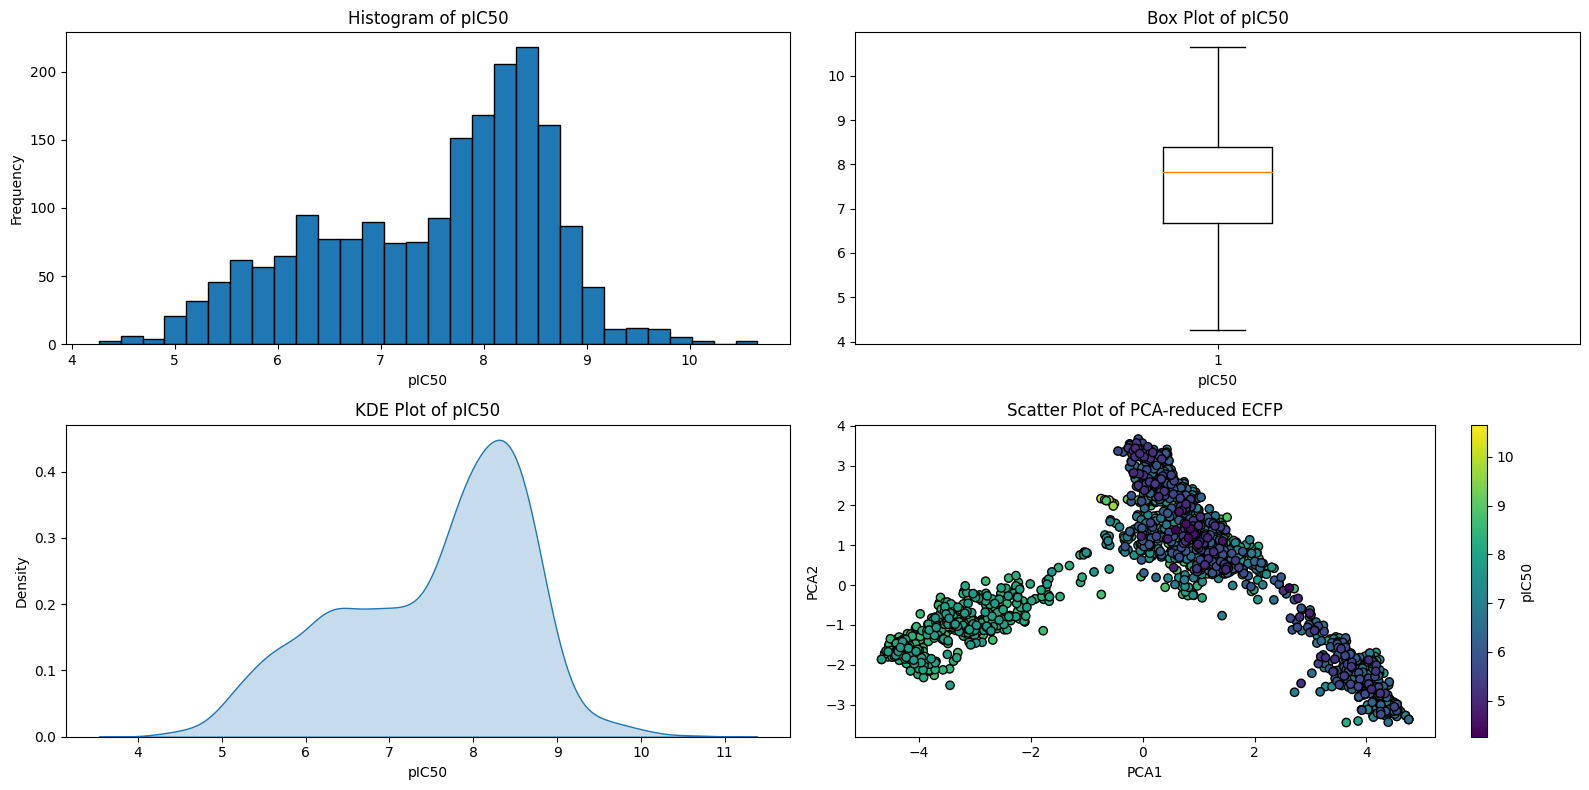

In [13]:
ecfp_array = np.array([list(fp) for fp in dataset['ECFP']])

# PCA를 사용하여 차원 축소
pca = PCA(n_components=2)
ecfp_pca = pca.fit_transform(ecfp_array)

# PCA 결과를 데이터프레임에 추가
dataset['PCA1'] = ecfp_pca[:, 0]
dataset['PCA2'] = ecfp_pca[:, 1]

# 데이터 분포 시각화
plt.figure(figsize=(16, 8))

# 'IC50_nM' 히스토그램
plt.subplot(2, 2, 1)
plt.hist(dataset['pIC50'], bins=30, edgecolor='k')
plt.title('Histogram of pIC50')
plt.xlabel('pIC50')
plt.ylabel('Frequency')

# 'pIC50' 박스 플롯
plt.subplot(2, 2, 2)
plt.boxplot(dataset['pIC50'])
plt.title('Box Plot of pIC50')
plt.xlabel('pIC50')

# 'pIC50' KDE 플롯
plt.subplot(2, 2, 3)
sns.kdeplot(dataset['pIC50'], shade=True)
plt.title('KDE Plot of pIC50')
plt.xlabel('pIC50')
plt.ylabel('Density')

# ECFP의 PCA 결과와 'pIC50' 산점도
plt.subplot(2, 2, 4)
scatter = plt.scatter(dataset['PCA1'], dataset['PCA2'], c=dataset['pIC50'], cmap='viridis', edgecolor='k')
plt.colorbar(scatter, label='pIC50')
plt.title('Scatter Plot of PCA-reduced ECFP')
plt.xlabel('PCA1')
plt.ylabel('PCA2')

plt.tight_layout()
plt.show()

- 데이터 분포: 대부분의 IC50_nM 값은 0 근처에 집중되어 있으며, 일부 값은 매우 큰 범위를 가짐
- 중앙값과 사분위수: 중앙값과 사분위수는 매우 낮으며, 많은 이상값이 존재함
- 밀도: IC50_nM 값의 밀도는 0 근처에서 매우 높고, 빠르게 감소함

<ipython-input-12-d4b6f0790ed1>:16: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(dataset['Log_IC50_nM'], shade=True)


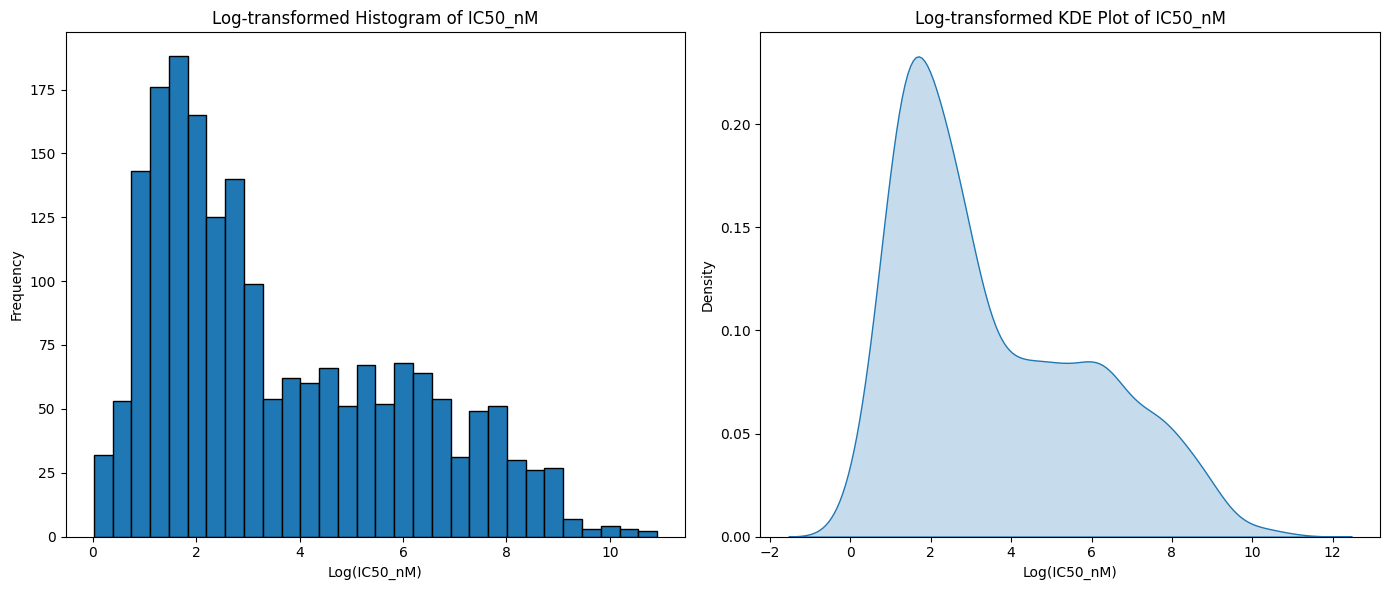

In [12]:
# 로그 변환
dataset['Log_IC50_nM'] = np.log1p(dataset['IC50_nM'])

# 히스토그램 및 KDE 플롯
plt.figure(figsize=(14, 6))

# 로그 변환된 히스토그램
plt.subplot(1, 2, 1)
plt.hist(dataset['Log_IC50_nM'], bins=30, edgecolor='k')
plt.title('Log-transformed Histogram of IC50_nM')
plt.xlabel('Log(IC50_nM)')
plt.ylabel('Frequency')

# 로그 변환된 KDE 플롯
plt.subplot(1, 2, 2)
sns.kdeplot(dataset['Log_IC50_nM'], shade=True)
plt.title('Log-transformed KDE Plot of IC50_nM')
plt.xlabel('Log(IC50_nM)')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

In [13]:
Q0 = dataset['pIC50'].quantile(0.0)
Q1 = dataset['pIC50'].quantile(0.25)
Q2 = dataset['pIC50'].quantile(0.50)
Q3 = dataset['pIC50'].quantile(0.75)
Q4 = dataset['pIC50'].quantile(1.0)

print(f"Q0: {Q0}")
print(f"Q1 (1st Quartile): {Q1}")
print(f"Q2 (Median): {Q2}")
print(f"Q3 (3rd Quartile): {Q3}")
print(f"Q4: {Q4}")

Q0: 4.26
Q1 (1st Quartile): 6.68
Q2 (Median): 7.82
Q3 (3rd Quartile): 8.39
Q4: 10.66


In [14]:
Q0 = dataset['Log_IC50_nM'].quantile(0.0)
Q1 = dataset['Log_IC50_nM'].quantile(0.25)
Q2 = dataset['Log_IC50_nM'].quantile(0.50)
Q3 = dataset['Log_IC50_nM'].quantile(0.75)
Q4 = dataset['Log_IC50_nM'].quantile(1.0)

print(f"Q0: {Q0}")
print(f"Q1 (1st Quartile): {Q1}")
print(f"Q2 (Median): {Q2}")
print(f"Q3 (3rd Quartile): {Q3}")
print(f"Q4: {Q4}")

Q0: 0.02176149178151269
Q1 (1st Quartile): 1.62924053973028
Q2 (Median): 2.7880881750255275
Q3 (3rd Quartile): 5.348045139731189
Q4: 10.915106645867503


# K-Means: center = test data

## Data Pre-processing

dataset2를 testset로 변경

In [ ]:
# smiles to ECFP fingerprint
testset = test_data[['Smiles']].copy()
testset.loc[:, 'ECFP'] = test_data['Smiles'].apply(generate_ecfp)

## Implement K-Means

In [16]:
train_ecfp_array = np.array(dataset['ECFP'].tolist())
test_ecfp_array = np.array(testset['ECFP'].tolist())

In [17]:
test_centers = test_ecfp_array

kmeans = KMeans(n_clusters=len(test_centers), init=test_centers, n_init=1, random_state=42)
kmeans.fit(train_ecfp_array)
labels = kmeans.labels_
cluster_centers = kmeans.cluster_centers_

## test data에 가까운 데이터로 구성된 새로운 데이터 생성

In [18]:
def find_top_n_closest(data, centers, labels, n=5):
    top_n_indices = []
    for i, center in enumerate(centers):
        cluster_data = data[labels == i]
        cluster_indices = np.where(labels == i)[0]
        distances = np.linalg.norm(cluster_data - center, axis=1)
        top_n_idx = distances.argsort()[:n]
        top_n_indices.extend(cluster_indices[top_n_idx])
        top_n_indices = list(set(top_n_indices))
    return top_n_indices

top_n = 3
top_n_indices = find_top_n_closest(train_ecfp_array, cluster_centers, labels, n=top_n)

selected_train_df = dataset.iloc[top_n_indices]
print(f"Original training data size: {dataset.shape}")
print(f"Selected training data size: {selected_train_df.shape}")

Original training data size: (1952, 6)
Selected training data size: (271, 6)


In [19]:
df1 = selected_train_df

In [20]:
df1

,Assay ChEMBL ID,IC50_nM,pIC50,Smiles,ECFP,PCA1,PCA2
0,4361896,0.022,10.66,CN[C@@H](C)C(=O)N[C@H](C(=O)N1C[C@@H](NC(=O)CC...,"[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",0.508679,1.193638
1,4345131,0.026,10.59,CC(C)(O)[C@H](F)CN1Cc2cc(NC(=O)c3cnn4cccnc34)c...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",-0.504608,2.045179
2,4345131,0.078,10.11,CC(C)(O)[C@H](F)CN1Cc2cc(NC(=O)c3cnn4cccnc34)c...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",-0.552536,2.075606
3,4345131,0.081,10.09,CC(C)(O)[C@H](F)CN1Cc2cc(NC(=O)c3cnn4cccnc34)c...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",-0.744538,2.173109
4,4361896,0.099,10.00,COc1cc2c(OC[C@@H]3CCC(=O)N3)ncc(C#CCCCCCCCCCCC...,"[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.001703,1.233588
...,...,...,...,...,...,...,...
1012,4022135,17.000,7.77,CN1CCN([C@H]2CC[C@H](Nc3ncnc4ccc(C#N)cc34)CC2)CC1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, ...",0.821273,-0.054637
504,3887118,4.300,8.37,CC(C)n1cc(Nc2cc(-n3cnc4cc(Cl)cnc43)ncc2C(=O)NC...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",-3.209029,-0.214997
1018,3887118,17.500,7.76,CC(C)C(O)CNc1cc(-n2ncc3cc(Cl)cnc32)ncc1C(=O)NC...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",-3.515323,-0.724906
508,3887118,4.300,8.37,CC(C)Nc1cc(-n2ccc3cc(CNC(=O)CC4CCCC4)cnc32)ncc...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",-3.264291,-1.086013


# K-NN: Select training data

In [20]:
from sklearn.neighbors import NearestNeighbors

# Nearest Neighbors를 사용하여 테스트 데이터에 가장 가까운 학습 데이터를 찾기
nn = NearestNeighbors(n_neighbors=5, metric='jaccard')
nn.fit(train_ecfp_array)
distances, indices = nn.kneighbors(test_ecfp_array)

# 가장 가까운 학습 데이터를 기반으로 새로운 학습 데이터셋 생성
selected_train_indices = np.unique(indices.flatten())
selected_train_df2 = dataset.iloc[selected_train_indices]

# 원래 학습 데이터와 선택된 학습 데이터를 비교하여 크기 확인
print(f"Original training data size: {dataset.shape}")
print(f"Selected training data size: {selected_train_df2.shape}")

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/pairwise.py:2182: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


Original training data size: (1952, 6)
Selected training data size: (112, 6)


In [21]:
df2 = selected_train_df2

# LLM: GPT-4o

In [1]:
!pip install --upgrade openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 360.7/360.7 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.9/318.9 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 2.2 MB/s eta 0:00:00


In [2]:
import openai
from openai import OpenAI
import os
OPENAI_API_KEY = 'sk-'
client = OpenAI(api_key=OPENAI_API_KEY)

## GPT API 사용: K-NN

### random 30

In [22]:
train_df2, test_df2 = train_test_split(df2, test_size=0.2, random_state=42)

random_indices = random.sample(range(train_df2.shape[0]), 30)
random_samples = train_df2.iloc[random_indices]

# 시스템 프롬프트
system_prompt = ""
for idx, (smiles, assay_id, actual_ic50) in enumerate(zip(random_samples['Smiles'], random_samples['Assay ChEMBL ID'], random_samples['IC50_nM'])):
    system_prompt += f"Smiles가 {smiles}일 때 Assay ChEMBL ID {assay_id}에 붙는 IC50은 실제값 {actual_ic50} nM\n"

system_prompt += '입력하는 Smiles에 대해서 IC50을 예측하여 답한다. 숫자로만 응답할 것.(예: 0.022, 0.026, 0.099 등)'

In [23]:
def get_gpt_response(prompt, model="gpt-4o"):
    response = client.chat.completions.create(
        model=model,
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": prompt}
        ],
        max_tokens=150,
        n=1,
        stop=None,
        temperature=0
    )
    return response.choices[0].message.content

In [24]:
# 테스트 데이터 예측
predicted_ic50 = []
actual_ic50 = []

for smiles in test_df2['Smiles']:
    predicted_ic50.append(get_gpt_response(f"Smiles가 {smiles}일 때 IC50 예측값(숫자)을 답할 것"))

actual_ic50 = test_df2['IC50_nM'].tolist()

RateLimitError: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}

In [ ]:
processed_ic50 = []

for response in predicted_ic50:
    try:
        # 문자열에서 숫자만 추출
        number = float(response)
        processed_ic50.append(number)
    except ValueError:
        # '알 수 없음' 등
        processed_ic50.append(0.0)

processed_ic50

[4.4,
 5.0,
 0.099,
 4.7,
 2.0,
 0.026,
 1.4,
 4.0,
 0.004,
 15.0,
 0.139,
 0.34,
 0.015,
 0.16,
 0.139,
 4.0,
 2.9,
 100.0,
 0.099,
 0.139,
 0.026,
 3.0,
 0.005]

In [ ]:
mae = mean_absolute_error(actual_ic50, processed_ic50)
r2 = r2_score(actual_ic50, processed_ic50)

print(f"Mean Absolute Error: {mae}")
print(f"R2 Score: {r2}")

Mean Absolute Error: 80.08734782608695
R2 Score: -0.12457946329932978


### selected train data 전체 : ECFP

In [ ]:
train_df2, test_df2 = train_test_split(df2, test_size=0.2, random_state=42)

In [ ]:
# 시스템 프롬프트
system_prompt = ""
for idx, (smiles, assay_id, actual_ic50) in enumerate(zip(train_df2['Smiles'], train_df2['Assay ChEMBL ID'], train_df2['IC50_nM'])):
    system_prompt += f"Smiles가 {smiles}일 때 Assay ChEMBL ID {assay_id}에 붙는 IC50은 실제값 {actual_ic50} nM\n"

system_prompt += '입력하는 Smiles에 대해서 IC50을 예측하여 답한다. 숫자로만 응답할 것.(예: 0.022, 0.026, 0.099 등)'

In [ ]:
predicted_ic50 = []
actual_ic50 = []

for smiles in test_df2['Smiles']:
    predicted_ic50.append(get_gpt_response(f"Smiels가 {smiles}일 때 IC50 예측값(숫자)을 답할 것"))

actual_ic50 = test_df2['IC50_nM'].tolist()

In [ ]:
processed_ic50 = []

for response in predicted_ic50:
    try:
        # 문자열에서 숫자만 추출
        number = float(response)
        processed_ic50.append(number)
    except ValueError:
        # '알 수 없음' 등
        processed_ic50.append(0.0)

processed_ic50

[4.4,
 0.035,
 0.031,
 0.003,
 1.9,
 0.011,
 1.4,
 3.3,
 10.1,
 0.015,
 0.012,
 0.167,
 0.009,
 0.16,
 2.0,
 3.3,
 0.01,
 100.0,
 0.254,
 0.113,
 5.2,
 3.0,
 0.095]

In [ ]:
mae = mean_absolute_error(actual_ic50, processed_ic50)
r2 = r2_score(actual_ic50, processed_ic50)

print(f"Mean Absolute Error: {mae}")
print(f"R2 Score: {r2}")

Mean Absolute Error: 80.65586956521739
R2 Score: -0.12457407101094109


## GPT API 사용: K-Means

### random 30

In [ ]:
train_df1, test_df1 = train_test_split(df1, test_size=0.2, random_state=42)

random_indices = random.sample(range(train_df1.shape[0]), 30)
random_samples = train_df1.iloc[random_indices]

# 시스템 프롬프트
system_prompt_m = ""
for idx, (ecfp, assay_id, actual_ic50) in enumerate(zip(random_samples['ECFP'], random_samples['Assay ChEMBL ID'], random_samples['IC50_nM'])):
    system_prompt_m += f"ECFP가 {ecfp}일 때 Assay ChEMBL ID {assay_id}에 붙는 IC50은 실제값 {actual_ic50} nM\n"

system_prompt_m += '입력하는 ECFP에 대해서 IC50을 예측하여 답한다. 숫자로만 응답할 것.(예: 0.022, 0.026, 0.099 등)'

In [ ]:
def get_gpt_response(prompt, model="gpt-4o"):
    response = client.chat.completions.create(
        model=model,
        messages=[
            {"role": "system", "content": system_prompt_m},
            {"role": "user", "content": prompt}
        ],
        max_tokens=150,
        n=1,
        stop=None,
        temperature=0
    )
    return response.choices[0].message.content

In [ ]:
# 테스트 데이터 예측
predicted_ic50 = []
actual_ic50 = []

for smiles in test_df1['Smiles']:
    predicted_ic50.append(get_gpt_response(f"Smiles가 {smiles}일 때 IC50 예측값(숫자)을 답할 것"))

actual_ic50 = test_df1['IC50_nM'].tolist()

In [ ]:
processed_ic50 = []

for response in predicted_ic50:
    try:
        # 문자열에서 숫자만 추출
        number = float(response)
        processed_ic50.append(number)
    except ValueError:
        # '알 수 없음' 등
        processed_ic50.append(0.0)

processed_ic50

[0.026,
 0.026,
 0.026,
 0.026,
 5.3,
 0.026,
 0.026,
 4.5,
 0.026,
 0.026,
 0.026,
 0.026,
 0.026,
 0.026,
 0.026,
 0.026,
 0.026,
 5.3,
 0.026,
 0.026,
 0.026,
 0.026,
 0.026,
 0.026,
 0.026,
 0.026,
 0.026,
 0.026,
 0.026,
 0.026,
 0.026,
 0.026,
 0.026,
 0.026,
 0.026,
 0.026,
 0.026,
 0.026,
 0.026,
 0.026,
 0.026,
 0.026,
 0.026,
 6.9,
 0.026,
 0.026,
 6.9,
 0.026,
 0.026,
 5.3,
 0.026,
 5.3,
 4.5,
 0.026,
 0.026]

In [ ]:
mae = mean_absolute_error(actual_ic50, processed_ic50)
r2 = r2_score(actual_ic50, processed_ic50)

print(f"Mean Absolute Error: {mae}")
print(f"R2 Score: {r2}")

Mean Absolute Error: 596.7256000000001
R2 Score: -0.08090973795425249


In [ ]:
log_y_true = np.log1p(test_df1['IC50_nM'])
log_y_pred = np.log1p(processed_ic50)
log_mae = mean_absolute_error(log_y_true, log_y_pred)
print(f"Log-transformed MAE: {log_mae}")

Log-transformed MAE: 3.047694264351245


<ipython-input-62-5e6391c58227>:20: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(dataset['IC50_nM'], shade=True)
<ipython-input-62-5e6391c58227>:27: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(dataset['Log_IC50_nM'], shade=True)


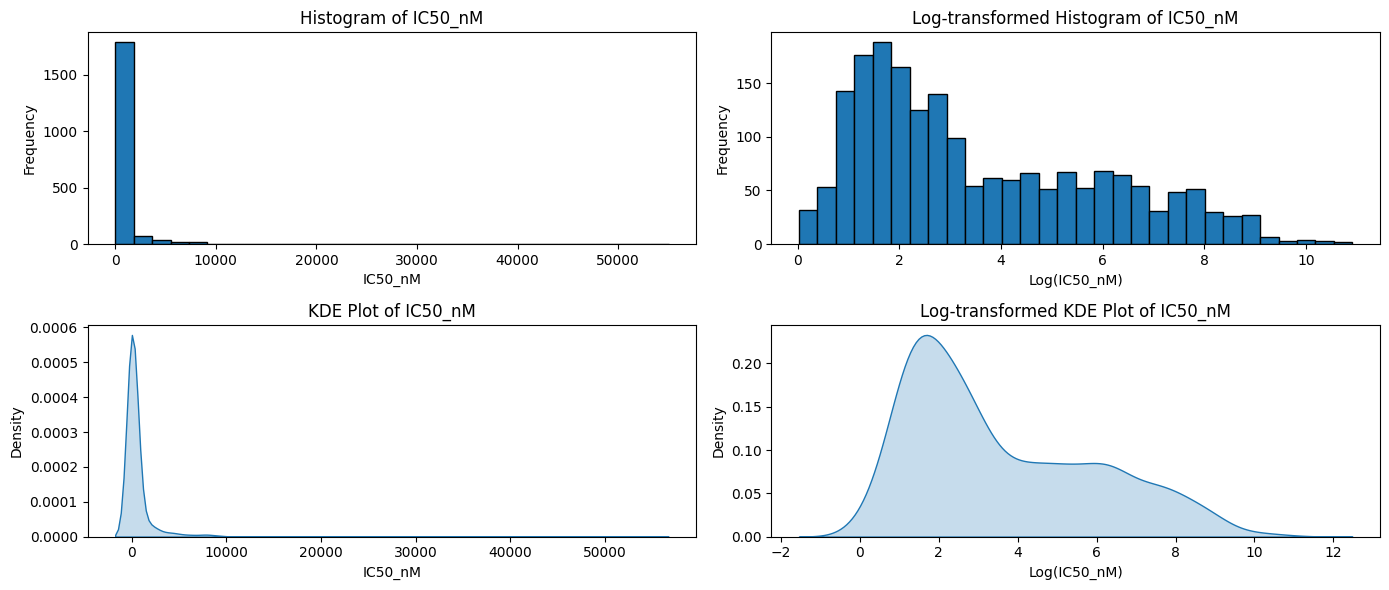

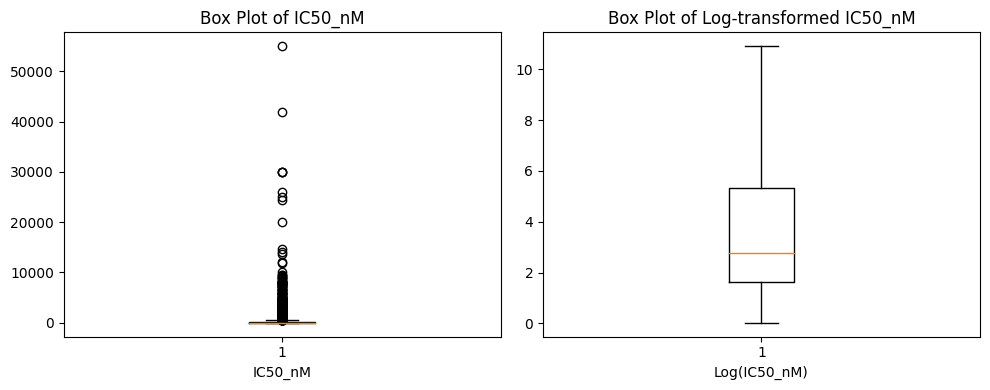

In [ ]:
# 히스토그램 및 KDE 플롯 비교
plt.figure(figsize=(14, 6))

# 원래 값 히스토그램
plt.subplot(2, 2, 1)
plt.hist(dataset['IC50_nM'], bins=30, edgecolor='k')
plt.title('Histogram of IC50_nM')
plt.xlabel('IC50_nM')
plt.ylabel('Frequency')

# 로그 변환된 값 히스토그램
plt.subplot(2, 2, 2)
plt.hist(dataset['Log_IC50_nM'], bins=30, edgecolor='k')
plt.title('Log-transformed Histogram of IC50_nM')
plt.xlabel('Log(IC50_nM)')
plt.ylabel('Frequency')

# 원래 값 KDE 플롯
plt.subplot(2, 2, 3)
sns.kdeplot(dataset['IC50_nM'], shade=True)
plt.title('KDE Plot of IC50_nM')
plt.xlabel('IC50_nM')
plt.ylabel('Density')

# 로그 변환된 값 KDE 플롯
plt.subplot(2, 2, 4)
sns.kdeplot(dataset['Log_IC50_nM'], shade=True)
plt.title('Log-transformed KDE Plot of IC50_nM')
plt.xlabel('Log(IC50_nM)')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

# 박스 플롯 비교
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.boxplot(dataset['IC50_nM'])
plt.title('Box Plot of IC50_nM')
plt.xlabel('IC50_nM')

plt.subplot(1, 2, 2)
plt.boxplot(dataset['Log_IC50_nM'])
plt.title('Box Plot of Log-transformed IC50_nM')
plt.xlabel('Log(IC50_nM)')

plt.tight_layout()
plt.show()

### selected train data 전체 : ECFP

In [ ]:
train_df1, test_df1 = train_test_split(df1, test_size=0.2, random_state=42)

# 시스템 프롬프트
system_prompt_m = ""
for idx, (smiles, assay_id, actual_ic50) in enumerate(zip(train_df1['Smiles'], train_df1['Assay ChEMBL ID'], train_df1['IC50_nM'])):
    system_prompt_m += f"Smiles가 {smiles}일 때 Assay ChEMBL ID {assay_id}에 붙는 IC50은 실제값 {actual_ic50} nM\n"

system_prompt_m += '입력하는 Smiles에 대해서 IC50을 예측하여 답한다. 숫자로만 응답할 것.(예: 0.022, 0.026, 0.099 등)'

In [ ]:
import time

In [ ]:
def get_gpt_response(prompt, model="gpt-4o"):
    try:
        response = client.chat.completions.create(
            model=model,
            messages=[
                {"role": "system", "content": system_prompt_m},
                {"role": "user", "content": prompt}
            ],
            max_tokens=150,
            n=1,
            stop=None,
            temperature=0
        )
        return response.choices[0].message.content
    except openai.RateLimitError:
        print("Rate limit exceeded. Waiting for 10 seconds before retrying...")
        time.sleep(10)
        return get_gpt_response(prompt, model)

In [ ]:
sampled_test_df1 = test_df1.sample(n=5, random_state=42)

In [ ]:
# 테스트 데이터 예측
predicted_ic50 = []
actual_ic50 = []

for smiles in sampled_test_df1['Smiles']:
    predicted_ic50.append(get_gpt_response(f"Smiles가 {smiles}일 때 IC50 예측값(숫자)을 답할 것"))

actual_ic50 = test_df1['IC50_nM'].tolist()

Rate limit exceeded. Waiting for 10 seconds before retrying...
Rate limit exceeded. Waiting for 10 seconds before retrying...
Rate limit exceeded. Waiting for 10 seconds before retrying...
Rate limit exceeded. Waiting for 10 seconds before retrying...
Rate limit exceeded. Waiting for 10 seconds before retrying...
Rate limit exceeded. Waiting for 10 seconds before retrying...
Rate limit exceeded. Waiting for 10 seconds before retrying...
Rate limit exceeded. Waiting for 10 seconds before retrying...
Rate limit exceeded. Waiting for 10 seconds before retrying...
Rate limit exceeded. Waiting for 10 seconds before retrying...
Rate limit exceeded. Waiting for 10 seconds before retrying...
Rate limit exceeded. Waiting for 10 seconds before retrying...
Rate limit exceeded. Waiting for 10 seconds before retrying...
Rate limit exceeded. Waiting for 10 seconds before retrying...
Rate limit exceeded. Waiting for 10 seconds before retrying...
Rate limit exceeded. Waiting for 10 seconds before retr

KeyboardInterrupt: 

In [ ]:
processed_ic50 = []

for response in predicted_ic50:
    try:
        # 문자열에서 숫자만 추출
        number = float(response)
        processed_ic50.append(number)
    except ValueError:
        # '알 수 없음' 등
        processed_ic50.append(0.0)

processed_ic50

In [ ]:
mae = mean_absolute_error(actual_ic50, processed_ic50)
r2 = r2_score(actual_ic50, processed_ic50)

print(f"Mean Absolute Error: {mae}")
print(f"R2 Score: {r2}")

# pIC50 & Random Forest

In [37]:
train_df1, test_df1 = train_test_split(df1, test_size=0.2, random_state=42)

model = RandomForestRegressor(random_state=42)
model.fit(list(train_df1['ECFP']), train_df1['pIC50'])

test_predictions = model.predict(list(test_df1['ECFP']))

mae = mean_absolute_error(test_df1['pIC50'], test_predictions)
r2 = r2_score(test_df1['pIC50'], test_predictions)

print(f"Mean Absolute Error: {mae}")
print(f"R^2 Score: {r2}")

test_results = test_df1.copy()
test_results['Predicted_pIC50'] = test_predictions

Mean Absolute Error: 0.6107703030303026
R^2 Score: 0.4447010321217033


In [39]:
# pIC50을 IC50으로 변환
test_predictions_ic50 = np.power(10, -test_predictions)
test_true_ic50 = np.power(10, -test_df1['pIC50'])

# 평가
mae = mean_absolute_error(test_true_ic50, test_predictions_ic50)
r2 = r2_score(test_true_ic50, test_predictions_ic50)

print(f"Mean Absolute Error: {mae}")
print(f"R^2 Score: {r2}")

# RMSE 계산
rmse = sqrt(mean_squared_error(test_true_ic50, test_predictions_ic50))

# Normalized RMSE 계산
normalized_rmse = rmse / (np.max(test_true_ic50) - np.min(test_true_ic50))

# Absolute Error for pIC50
absolute_error_pIC50 = np.abs(test_df1['pIC50'] - test_predictions)

# Correct Ratio 계산 (절대 오차가 0.5 이하인 비율)
correct_ratio = np.mean(absolute_error_pIC50 <= 0.5)

# 종합 점수 계산
score = 0.5 * (1 - min(normalized_rmse, 1)) + 0.5 * correct_ratio

print(f"Normalized RMSE (A): {normalized_rmse}")
print(f"Correct Ratio (B): {correct_ratio}")
print(f"Score: {score}")

Mean Absolute Error: 5.65005256120282e-07
R^2 Score: -0.015501712991095706
Normalized RMSE (A): 0.14478298345029503
Correct Ratio (B): 0.5454545454545454
Score: 0.7003357810021251


In [40]:
df2 = selected_train_df2

train_df2, test_df2 = train_test_split(df2, test_size=0.2, random_state=42)

model = RandomForestRegressor(random_state=42)
model.fit(list(train_df2['ECFP']), train_df2['pIC50'])

test_predictions = model.predict(list(test_df2['ECFP']))

mae = mean_absolute_error(test_df2['pIC50'], test_predictions)
r2 = r2_score(test_df2['pIC50'], test_predictions)

print(f"Mean Absolute Error: {mae}")
print(f"R^2 Score: {r2}")

test_results = test_df2.copy()
test_results['Predicted_pIC50'] = test_predictions

Mean Absolute Error: 0.4837782608695678
R^2 Score: 0.3506151648819623


In [41]:
# pIC50을 IC50으로 변환
test_predictions_ic50 = np.power(10, -test_predictions)
test_true_ic50 = np.power(10, -test_df2['pIC50'])

# 평가
mae = mean_absolute_error(test_true_ic50, test_predictions_ic50)
r2 = r2_score(test_true_ic50, test_predictions_ic50)

print(f"Mean Absolute Error: {mae}")
print(f"R^2 Score: {r2}")

# RMSE 계산
rmse = sqrt(mean_squared_error(test_true_ic50, test_predictions_ic50))

# Normalized RMSE 계산
normalized_rmse = rmse / (np.max(test_true_ic50) - np.min(test_true_ic50))

# Absolute Error for pIC50
absolute_error_pIC50 = np.abs(test_df2['pIC50'] - test_predictions)

# Correct Ratio 계산 (절대 오차가 0.5 이하인 비율)
correct_ratio = np.mean(absolute_error_pIC50 <= 0.5)

# 종합 점수 계산
score = 0.5 * (1 - min(normalized_rmse, 1)) + 0.5 * correct_ratio

print(f"Normalized RMSE (A): {normalized_rmse}")
print(f"Correct Ratio (B): {correct_ratio}")
print(f"Score: {score}")

Mean Absolute Error: 6.555355204164565e-08
R^2 Score: 0.4442473862639895
Normalized RMSE (A): 0.15657166167547934
Correct Ratio (B): 0.6086956521739131
Score: 0.7260619952492169


# pIC50 & Gradient Boosting

In [43]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', GradientBoostingRegressor(random_state=42))
])

param_grid = {
    'regressor__n_estimators': [100, 200],
    'regressor__learning_rate': [0.01, 0.1, 0.2],
    'regressor__max_depth': [3, 5, 7]
}

# GridSearchCV를 사용한 하이퍼파라미터 튜닝 및 교차 검증
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(list(train_df1['ECFP']), train_df1['pIC50'])

# 최적의 모델로 예측 수행
best_model = grid_search.best_estimator_
test_predictions = best_model.predict(list(test_df1['ECFP']))

mae = mean_absolute_error(test_df1['pIC50'], test_predictions)
r2 = r2_score(test_df1['pIC50'], test_predictions)

print(f"Mean Absolute Error: {mae}")
print(f"R^2 Score: {r2}")

test_results = test_df1.copy()
test_results['Predicted_pIC50'] = test_predictions

Mean Absolute Error: 0.5842992362307492
R^2 Score: 0.4373587529494589


In [44]:
# pIC50을 IC50으로 변환
test_predictions_ic50 = np.power(10, -test_predictions)
test_true_ic50 = np.power(10, -test_df1['pIC50'])

# 평가
mae = mean_absolute_error(test_true_ic50, test_predictions_ic50)
r2 = r2_score(test_true_ic50, test_predictions_ic50)

print(f"Mean Absolute Error: {mae}")
print(f"R^2 Score: {r2}")

# RMSE 계산
rmse = sqrt(mean_squared_error(test_true_ic50, test_predictions_ic50))

# Normalized RMSE 계산
normalized_rmse = rmse / (np.max(test_true_ic50) - np.min(test_true_ic50))

# Absolute Error for pIC50
absolute_error_pIC50 = np.abs(test_df1['pIC50'] - test_predictions)

# Correct Ratio 계산 (절대 오차가 0.5 이하인 비율)
correct_ratio = np.mean(absolute_error_pIC50 <= 0.5)

# 종합 점수 계산
score = 0.5 * (1 - min(normalized_rmse, 1)) + 0.5 * correct_ratio

print(f"Normalized RMSE (A): {normalized_rmse}")
print(f"Correct Ratio (B): {correct_ratio}")
print(f"Score: {score}")

Mean Absolute Error: 5.875375494283551e-07
R^2 Score: -0.05998202750350057
Normalized RMSE (A): 0.14791984473068248
Correct Ratio (B): 0.6181818181818182
Score: 0.7351309867255679


In [45]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', GradientBoostingRegressor(random_state=42))
])

param_grid = {
    'regressor__n_estimators': [100, 200],
    'regressor__learning_rate': [0.01, 0.1, 0.2],
    'regressor__max_depth': [3, 5, 7]
}

# GridSearchCV를 사용한 하이퍼파라미터 튜닝 및 교차 검증
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(list(train_df2['ECFP']), train_df2['pIC50'])

# 최적의 모델로 예측 수행
best_model = grid_search.best_estimator_
test_predictions = best_model.predict(list(test_df2['ECFP']))

mae = mean_absolute_error(test_df2['pIC50'], test_predictions)
r2 = r2_score(test_df2['pIC50'], test_predictions)

print(f"Mean Absolute Error: {mae}")
print(f"R^2 Score: {r2}")

test_results = test_df2.copy()
test_results['Predicted_pIC50'] = test_predictions

Mean Absolute Error: 0.499536513253422
R^2 Score: 0.33253494089513713


In [46]:
# pIC50을 IC50으로 변환
test_predictions_ic50 = np.power(10, -test_predictions)
test_true_ic50 = np.power(10, -test_df2['pIC50'])

# 평가
mae = mean_absolute_error(test_true_ic50, test_predictions_ic50)
r2 = r2_score(test_true_ic50, test_predictions_ic50)

print(f"Mean Absolute Error: {mae}")
print(f"R^2 Score: {r2}")

# RMSE 계산
rmse = sqrt(mean_squared_error(test_true_ic50, test_predictions_ic50))

# Normalized RMSE 계산
normalized_rmse = rmse / (np.max(test_true_ic50) - np.min(test_true_ic50))

# Absolute Error for pIC50
absolute_error_pIC50 = np.abs(test_df2['pIC50'] - test_predictions)

# Correct Ratio 계산 (절대 오차가 0.5 이하인 비율)
correct_ratio = np.mean(absolute_error_pIC50 <= 0.5)

# 종합 점수 계산
score = 0.5 * (1 - min(normalized_rmse, 1)) + 0.5 * correct_ratio

print(f"Normalized RMSE (A): {normalized_rmse}")
print(f"Correct Ratio (B): {correct_ratio}")
print(f"Score: {score}")

Mean Absolute Error: 7.113808261254644e-08
R^2 Score: 0.5381027860861987
Normalized RMSE (A): 0.14273979710486298
Correct Ratio (B): 0.6521739130434783
Score: 0.7547170579693077
